# Custom training loops basics

https://github.com/sasidhar-programmer/Tensorflow_Advance_Techniques/blob/main/2-custom_and_distributed_training/week-2/C2_W2_Lab_1_training-basics.ipynb

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import numpy as numpy
import matplotlib.pyplot as plt

## Defining the model
- x is the input tensor
- the model outputs `wx+b` 
- w and b are random at first, but then we keep updating them to minimize the loss this is called "training"
- Once we get to the optimal values for w and b the model would have been trained to correctly predict `wx+b` ie `y` or the label


Hence,

* __w__ and __b__ are trainable weights of the model
* __x__ is the input
* __y=wx+b__ is the output

In [7]:
class Model():
    def __init__(self):
        # we init weights=2 and bias=1, in practice these should be randomly inited
        self.w = tf.Variable(2.0)
        self.b = tf.Variable(1.0)

    def __call__(self, x):
        return self.w * x +self.b

model = Model()



The loss measures how far the prediction is from the true target value
we will use the standard L2 loss also called as the Least Square Error

$$
loss = \Sigma_i(y_{pred}^i - y_{target}^i)^2
$$

In [34]:
def loss(y_predicted, y_target):
    s = tf.square(y_predicted - y_target)
    return tf.reduce_mean(s)

#### Start by making a model to predict the coffiecinet and offset of the linear function

$$y = 3x + 2$$

In [10]:
# creating dummy input tensor x and output tensor y using w=3 and b=2 coffecients

true_w = 3.0
true_b = 2.0
num_examples = 1000

x = tf.random.normal(shape=[num_examples]) # creates random values for x
y = (true_w * x) + true_b

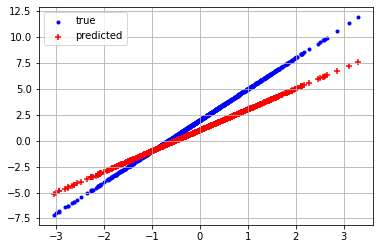

current loss between true and prediction is 1.953115


In [15]:
### before training lets compare the true y values and predicted y values
#  this will show us the difference between then and help us visualize the loss
def plot_data(inputs, outputs, predicted_outputs):
     true = plt.scatter(inputs, outputs, c='b', marker='.')
     predicted = plt.scatter(inputs, predicted_outputs, c='r', marker='+')
     plt.legend((true, predicted), ("true", "predicted"))
     plt.grid()
     plt.show()

plot_data(x, y, model(x))

print("current loss between true and prediction is %1.6f" % loss(model(x), y).numpy() )

This result above is predictable since the model's paramerters are hardcoded to be w=2 and b=1 while the true values are w_true=3 and b_true=2

And the loss function takes the difference between the true and predicted labels and computes a single scaler loss.

We can train the model to reduce the loss using Gradient descent (GD), GD updates the trainable weights and bias w and b to reduce the loss, `tf.train.Optimizer` has many varients of gradient descent, but here we will do the math ourselves using gradient tape.

We'll use `tf.GradientTape` for automatic differentiation and `tf.assign_sub` to update trainable parameters which is just a short hand for calling `tf.assign` and `tf.sub`

In [16]:
# this function does gradient descent to minimize the loss, so taking the derivative of the loss with 
# respect to both w and b (gradient), and subtract both w and b from the gradient times learning rate
# for example new_w = w - (learning_rate * dL/dw)
def train(model, inputs, outputs, learning_rate):
    with tf.GradientTape() as tape:
        current_loss = loss(model(inputs), outputs)

    dw, db = tape.gradient(current_loss, [model.w, model.b]) # derivative of loss with respect to weights and bias so dL/dw and dL/db

    # here we update the model's w and b like this: new_w = w - (learning_rate * dL/dw)
    model.w.assign_sub(learning_rate * dw)
    model.b.assign_sub(learning_rate * db)

    return current_loss


In [21]:
# Now we do the training loop wooboo!

model = Model()
EPOCHS_NUM = 15

list_w, list_b = [], [] # collect history of w and b to plot later
epochs = range(EPOCHS_NUM)
losses = []

for epoch in epochs:
    list_w.append(model.w.numpy())
    list_b.append(model.b.numpy())
    current_loss = train(model, x,y, learning_rate=0.1)
    losses.append(current_loss)
    print(f"Epoch {epoch}: w=%1.2f b=%1.2f loss=%2.3f" % (list_w[-1], list_b[-1], current_loss) )

Epoch 0: w=2.00 b=1.00 loss=1.953
Epoch 1: w=2.20 b=1.20 loss=1.265
Epoch 2: w=2.35 b=1.35 loss=0.819
Epoch 3: w=2.48 b=1.48 loss=0.530
Epoch 4: w=2.58 b=1.58 loss=0.343
Epoch 5: w=2.66 b=1.66 loss=0.222
Epoch 6: w=2.73 b=1.73 loss=0.144
Epoch 7: w=2.78 b=1.78 loss=0.093
Epoch 8: w=2.82 b=1.82 loss=0.060
Epoch 9: w=2.86 b=1.86 loss=0.039
Epoch 10: w=2.89 b=1.89 loss=0.025
Epoch 11: w=2.91 b=1.91 loss=0.016
Epoch 12: w=2.93 b=1.93 loss=0.011
Epoch 13: w=2.94 b=1.94 loss=0.007
Epoch 14: w=2.95 b=1.95 loss=0.004


Notice how at the last epoch the loss is minimal and the values of w and b are very close to the right values of 3 and 2

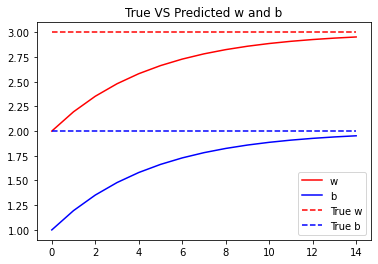

In [24]:
plt.plot(epochs, list_w, 'r',
       epochs, list_b, 'b')

plt.plot([true_w] * len(epochs), 'r--',
      [true_b] * len(epochs), 'b--')
plt.title("True VS Predicted w and b")

plt.legend(['w', 'b', 'True w', 'True b'])
plt.show()

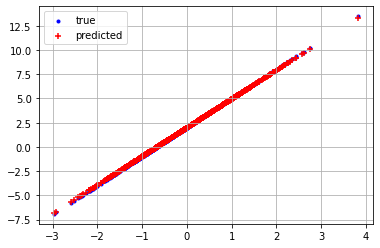

In [25]:
# After training we ssee that the model and the true data are very close now

test_inputs = tf.random.normal(shape=[num_examples])
test_outputs = test_inputs * true_w + true_b


predicted_outputs_test = model(test_inputs)
plot_data(test_inputs, test_outputs, predicted_outputs_test)

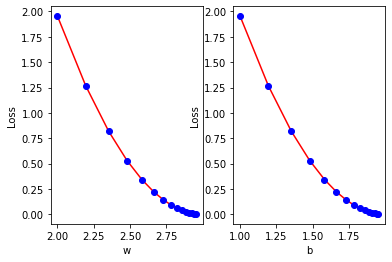

In [33]:
# drawing the loss vs w and loss vs b
# see that as w and b updates the loss gets lower and lower
# This is GRADIENT DESCENT woohoo! we see that the ball is rolling down the error curve till it reaches minimum!! good job!

def plot_loss_for_weights(weights_list, losses):
  for idx, weights in enumerate(weights_list):
    plt.subplot(120 + idx + 1)
    # lossess is the model current loss
    # the "values" is the parameter (w or b) current value
    plt.plot(weights['values'], losses, 'r')
    plt.plot(weights['values'], losses, 'bo')
    plt.xlabel(weights['name'])
    plt.ylabel('Loss')
    
    
weights_list = [{ 'name' : "w",
                  'values' : list_w
                },
                {
                  'name' : "b",
                  'values' : list_b
                }]

plot_loss_for_weights(weights_list, losses)
